In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import ray
import ray.rllib.agents.ppo as ppo
import ray.rllib.agents.ddpg as ddpg
import ray.rllib.agents.sac as sac
import seagul.envs
import numpy as np
from numpy import pi
import gym
from mpl_toolkits.mplot3d import Axes3D


In [4]:
# !! modify these as appropiate

home_path = '/home/sgillen/work/'

checkpoint_path = home_path + \
"seagul/seagul/notebooks/lorenz/data/bench_model/PPO/PPO_lorenz-v0_6f7a9b55_2020-01-29_16-42-474g5scof0/checkpoint_228/checkpoint-228"

In [5]:
# Some delightfully ugly python to infer where everything else is...
csv_path = '/'.join(checkpoint_path.split('/')[:-2]) + '/progress.csv'
save_name = checkpoint_path.split('/')[-3]
expr_file = "/experiment_state-" + save_name[-27:-8] + ".json"
expr_path = '/'.join(checkpoint_path.split('/')[:-3]) + expr_file

expr_data = json.load(open(expr_path))
config = expr_data['checkpoints'][-1]['config']
env_name = config['env']


df = pd.read_csv(csv_path)
#df

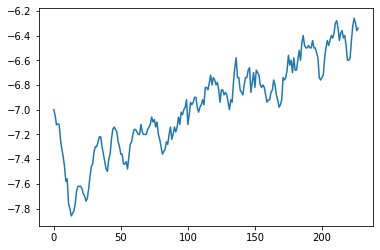

In [6]:
plt.plot(df['episode_reward_mean'])

In [7]:
ray.shutdown()
ray.init()

# !! change this line to reflect the algorithm you used
trainer = ppo.PPOTrainer(config)#, config['env_name'])
#trainer = ddpg.DDPGTrainer(config)
#trainer = sac.SACTrainer(config)
trainer.restore(checkpoint_path)

2020-01-29 17:33:00,828	WARNING worker.py:675 -- WARNING: Not updating worker name since `setproctitle` is not installed. Install this with `pip install setproctitle` (or ray[debug]) to enable monitoring of worker processes.
2020-01-29 17:33:00,830	WARNING services.py:597 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-01-29 17:33:00,831	INFO resource_spec.py:216 -- Starting Ray with 1.51 GiB memory available for workers and up to 0.78 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-01-29 17:33:01,254	INFO trainer.py:371 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
2020-01-29 17:33:01,271	INFO trainer.py:512 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2020-01-29 17:33:04,675	WARNING util.py:45 -- Install gputil for GPU system monitoring.
2020-01-29 17:33:04,744	IN

In [38]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
%matplotlib inline

#env = gym.make(env_name)
#env.unwrapped.reset_model = det_reset_model

# !! this needs to reflect the environemnt you trained in
env = gym.make("lorenz-v0")
env._max_episode_steps = 100000
obs = env.reset()



action_hist = []
m_act_hist = []
obs_hist = []
reward_hist = []

done = False
while not done:
    # for some algorithms you can get the sample mean out, need to change the value on the index to match your env for now
    # mean_actions = out_dict['behaviour_logits'][:17]
    # actions = trainer.compute_action(obs.flatten())
    
    sampled_actions, _ , out_dict = trainer.compute_action(obs.flatten(),full_fetch=True)
    
    actions = sampled_actions
   
    
    obs, reward, done, _ = env.step(np.asarray(actions))
    
    # !! uncomment to render
    #env.render()
    
    action_hist.append(np.copy(actions))
    obs_hist.append(np.copy(obs))
    reward_hist.append(np.copy(reward))

    if done:
        break

print(sum(reward_hist))
print(len(obs_hist))
#plt.plot(action_hist)
#plt.figure()
#plt.figure()
#plt.plot(obs_hist)
#plt.figure()

-5.0
101


In [39]:
# Reminder that the bahavior logits that come out are the mean and logstd (not log mean, despite the name logit)
trainer.compute_action(obs, full_fetch=True)

(array([ 0.23773363,  0.1987578 , -0.0518892 ]),
 [],
 {'action_prob': 63.891693,
  'action_logp': 4.1571894,
  'vf_preds': -12.371121,
  'behaviour_logits': array([ 0.14403936,  0.14024685, -0.0275404 , -2.529173  , -2.6942005 ,
         -2.843229  ], dtype=float32)})

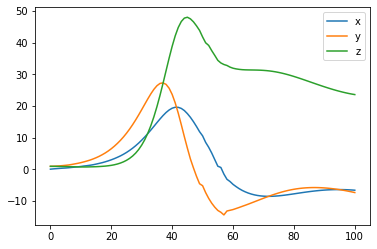

In [40]:
plt.plot(obs_hist)
plt.legend(['x', 'y', 'z'])

Text(0.5, 0.92, 'phase diagram, No control')

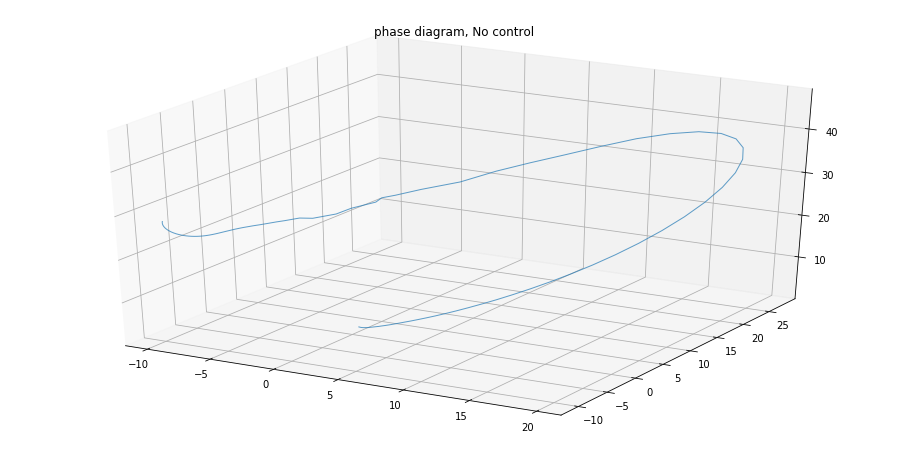

In [31]:
obs_arr = np.stack(obs_hist)

x = obs_arr[:,0]; y = obs_arr[:,1]; z = obs_arr[:,2]

fig = plt.figure(figsize=(16,8))
ax = fig.gca(projection='3d')
ax.plot(x,y,z, alpha=0.7, linewidth=1)
ax.set_title('phase diagram, No control')


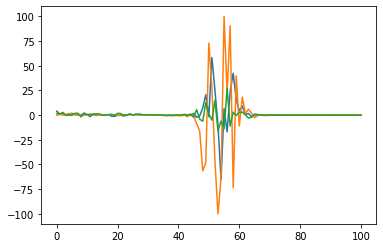

In [32]:
plt.plot(action_hist)